In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *
from pathlib import Path

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def get_DIV2k_data_QF(pLow, bs:int, sz:int):
    """Given the path of low resolution images
       returns a databunch
    """
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))
    
    data = (src.label_from_func(lambda x: path_fullRes/(x.name.replace(".jpg", ".png"))).transform(
            get_transforms(
                max_rotate=30,
                max_lighting=.4,
                max_warp=.4
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [3]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=7)

In [4]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_128 = path/'DIV2K_train_LR_128'
path_lowRes_256 = path/'DIV2K_train_LR_256'

proj_id = 'unet_superRes_mobilenetV3_SSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [5]:
print(path_fullRes)

dataset/DIV2K_train_HR


In [6]:
model = geffnet.mobilenetv3_rw

In [7]:
loss_func = msssim

# 128px

In [8]:
bs=10
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

In [9]:
data_gen = get_DIV2k_data_QF(path_lowRes_128, bs=bs, sz=sz)

In [10]:
x, y = data_gen.one_batch()

# LPIPS

In [11]:
mod = lpips.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, gpu_ids=[0])
d = mod.forward(x,y);

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [12]:
d.size()

torch.Size([10, 1, 1, 1])

In [13]:
d.mean()

tensor(0.3593, device='cuda:0', grad_fn=<MeanBackward0>)

# Brisque

In [14]:
from brisque import BRISQUE

In [15]:
brisque = BRISQUE()

In [16]:
x[0].shape

torch.Size([3, 256, 256])

In [17]:
x[0].permute(1, 2, 0).numpy().shape

(256, 256, 3)

In [18]:
brisque.get_score(x[0].permute(1, 2, 0).numpy())

117.04745252713286

In [19]:
values = []
for img in x:
    score = brisque.get_score(img.permute(1,2,0).numpy())
    values.append(score)

In [20]:
len(values)

10

# NIQE

In [21]:
%load_ext autoreload

In [22]:
%autoreload 2

In [23]:
from skvideo.measure.niqe import *
from torchvision import transforms

In [24]:
x[0][0].shape

torch.Size([256, 256])

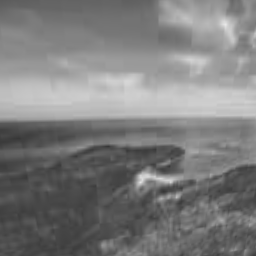

In [25]:
transforms.ToPILImage()(x[0][0]).convert("RGB")

In [26]:
values = []
for img in x:
    score = niqe(img[0].numpy())
    values.append(score)
values

[array([26.8212], dtype=float32),
 array([23.581226], dtype=float32),
 array([27.276867], dtype=float32),
 array([23.981064], dtype=float32),
 array([26.874329], dtype=float32),
 array([26.06172], dtype=float32),
 array([26.261862], dtype=float32),
 array([25.35957], dtype=float32),
 array([26.560095], dtype=float32),
 array([26.791565], dtype=float32)]

In [27]:
niqe(x[0][0].numpy())

array([26.8212], dtype=float32)

In [28]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [29]:
learn_gen.metrics.append(LPIPS_Metric())
learn_gen.metrics.append(BRISQUE_Metric())
learn_gen.metrics.append(NIQE_Metric())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


epoch,train_loss,valid_loss,lpips,brisque,niqe,time
0,0.196003,0.078359,0.411556,94.791094,22.819307,02:26


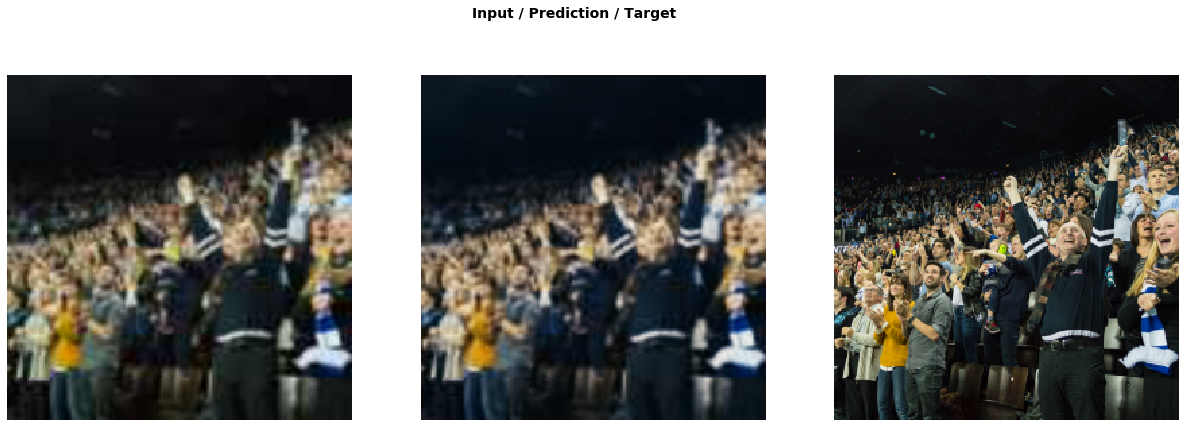

In [30]:
do_fit(learn_gen, epochs, gen_name+"_128px_0", slice(lr*10))